<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Xander Gallegos, Sergio Daniel Dueñas.

**Fecha:** 07 de marzo del 202X.

**Expediente** : 737989, XXXXXX.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/xagallegos/ProyectoConjunto_XGallegos_SDDuenas

# Tarea 4: Clase 11

## Enunciado de tarea
Programar redes neuronales para regresión para el siguiente dataset:


Las muestras contienen 12 atributos de casas en diferentes lugares alrededor del suburbios de Boston a fines de la década de 1970. Los objetivos son los valores medios de las casas en un lugar (en 1000s de dolares).


Los atributos mismos se definen en el [Sitio web de StatLib](http://lib.stat.cmu.edu/datasets/boston).


El diccionario de datos es el siguiente:

        CRIM: Per capita crime rate by town
        ZN: Proportion of residential land zoned for lots over 25,000 sq. ft
        INDUS: Proportion of non-retail business acres per town
        CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        NOX: Nitric oxide concentration (parts per 10 million)
        RM: Average number of rooms per dwelling
        AGE: Proportion of owner-occupied units built prior to 1940
        DIS: Weighted distances to five Boston employment centers
        RAD: Index of accessibility to radial highways
        TAX: Full-value property tax rate per $10,000
    PTRATIO: Pupil-teacher ratio by town
    LSTAT: Percentage of lower status of the population
    MEDV: Median value of owner-occupied homes in 1000s of dolars
    
El objetivo para es este dataset es el siguiente:
1. Construir una red neuronal MLP univariada. Para esto, escoger la variable que más tenga correlación con la variable de salida.
2. Construir una red neuronal MLP multivariada. Para esto, tomar todas las variables incluidas en nuestro dataset.
3. Construir una red neuronal MLP multivariada, pero en este caso sólo considerar las variables adecuadas y descartar aquellas que no aportan mucha información o que son redundantes para cuantificar el efecto de estas variables redundantes.

**Nota**: Para poder saber cuales variables incluir en el modelo y cuales rechazar una opción es analizar la correlación de pearson y la otra usando pruebas estadísiticas con las siguientes paqueterías
```
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
```
> Luego del paso 3, crear el mismo modelo pero en este caso implementar técnicas de regularización `EarlyStoppin` y `dropout`. Investigar como se pueden implementar estas estrategias en tensorflow.

### Ejercicio 1: 
Construir una red neuronal MLP univariada. Para esto, escoger la variable que más tenga correlación con la variable de salida.

Código de solución estudiante 1

In [34]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform, StandardScaler


### Lectura de datos

In [11]:
# Cargar datos
(X_train, y_train), (X_test, y_test) = keras.datasets.boston_housing.load_data()

# Eliminar variables con problemas éticos
X_train = np.delete(X_train, -2, axis=1)
X_test = np.delete(X_test, -2, axis=1)

In [147]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((404, 12), (404,), (102, 12), (102,))

In [148]:
columns = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'LSTAT',
    'MEDV'
]

X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test]).reshape(-1, 1)

data = pd.DataFrame(np.concatenate((X, y), axis=1), columns=columns)
data

#train_df = pd.DataFrame(np.concatenate((X_train, y_train.reshape(-1,1)), axis=1), columns=columns)
#test_df = pd.DataFrame(np.concatenate((X_test, y_test.reshape(-1,1)), axis=1), columns=columns)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,14.65,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,5.29,21.9
502,0.07896,0.0,12.83,0.0,0.437,6.273,6.0,4.2515,5.0,398.0,18.7,6.78,24.1
503,1.83377,0.0,19.58,1.0,0.605,7.802,98.2,2.0407,5.0,403.0,14.7,1.92,50.0
504,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,9.71,26.7


### Valores atípicos

In [121]:
def remove_outliers(df, column, threshold=1.5):
    df = df.copy()
    q1, q3 = np.percentile(df[column], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    
    df.loc[df[column] < lower_bound, column] = np.nan
    df.loc[df[column] > upper_bound, column] = np.nan
    
    return df[column]


In [150]:
clean_data = pd.DataFrame()

for col in data:
    clean_data[col] = remove_outliers(data, col)

### Distribución y simetría

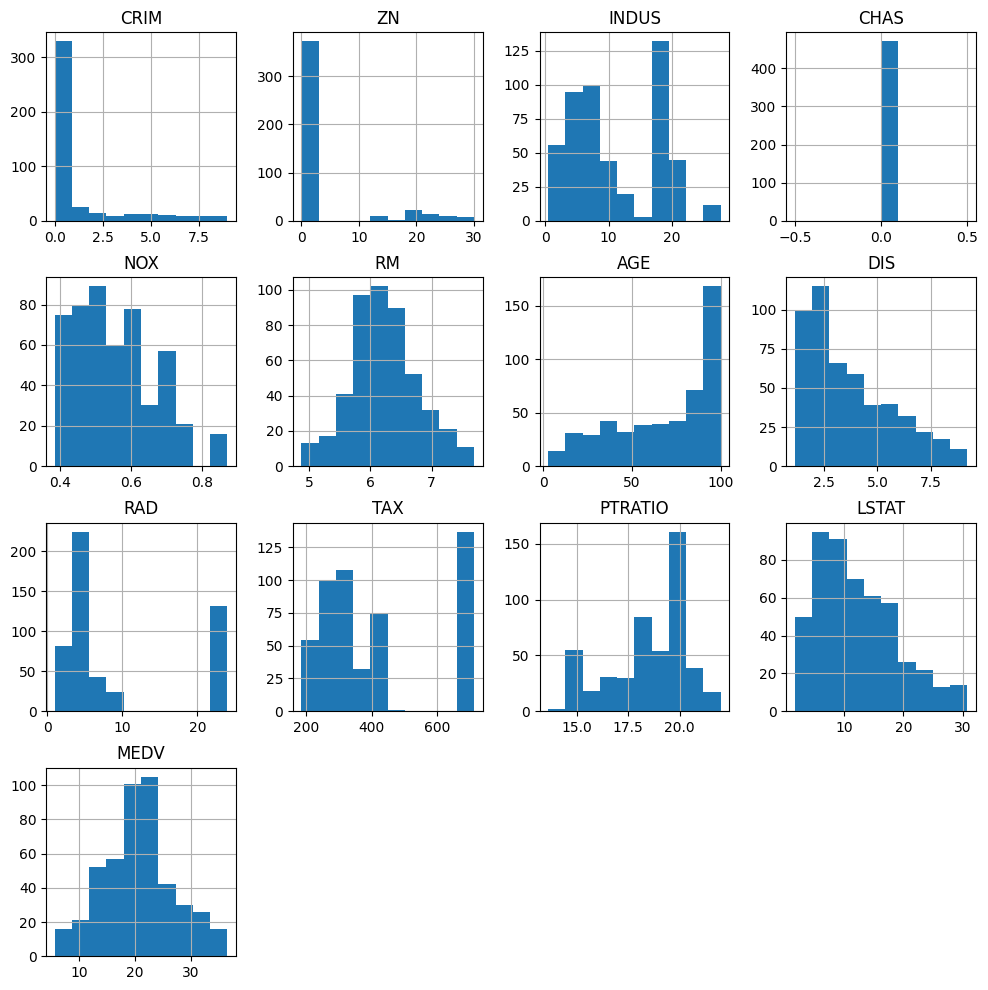

In [151]:
# La mayoría de las columnas tienen distribuciones asímetricas 
clean_data.hist(figsize=(12,12))
plt.show()

In [152]:
skew = pd.DataFrame(index=clean_data.columns)

skew['original'] = clean_data.skew()
skew['log'] = np.log(clean_data).skew()
skew['sqrt'] = np.sqrt(clean_data).skew()
skew['inv'] = np.power(clean_data, -1).skew()

In [153]:
skew

,original,log,sqrt,inv
CRIM,2.112688,0.452004,1.470623,3.568429
ZN,2.190945,NaN,2.025820,NaN
INDUS,0.295022,-0.643126,-0.072609,4.555905
CHAS,0.000000,NaN,0.000000,NaN
NOX,0.729308,0.357780,0.536789,-0.035386
RM,0.187942,-0.081475,0.054936,0.365365
AGE,-0.598963,-1.675655,-0.977466,5.992036
DIS,0.843752,0.113379,0.479809,0.643858
RAD,1.004815,0.286617,0.823844,2.505910
TAX,0.669956,0.330557,0.521793,0.191400


In [154]:
transformations = {char: skew.columns[np.argmin(np.abs(skew.loc[char]))] for char in skew.index}
transformations

{'CRIM': 'log',
 'ZN': 'sqrt',
 'INDUS': 'sqrt',
 'CHAS': 'original',
 'NOX': 'inv',
 'RM': 'sqrt',
 'AGE': 'original',
 'DIS': 'log',
 'RAD': 'log',
 'TAX': 'inv',
 'PTRATIO': 'original',
 'LSTAT': 'sqrt',
 'MEDV': 'original'}

In [156]:
def transform_column(data, how='original'):
    if how == 'original':
        trans = data
    elif how == 'log':
        trans = np.log(data)
    elif how == 'sqrt':
        trans = np.sqrt(data)
    elif how == 'inv':
        trans = np.power(data, -1)
    else:
        raise ValueError(f'Method {how} does not exist')
    
    return trans

In [157]:
trans_data = pd.DataFrame()

for col in clean_data.columns:
    col_name = col + '_' + transformations[col]
    trans_data[col_name] = transform_column(clean_data[col], transformations[col])

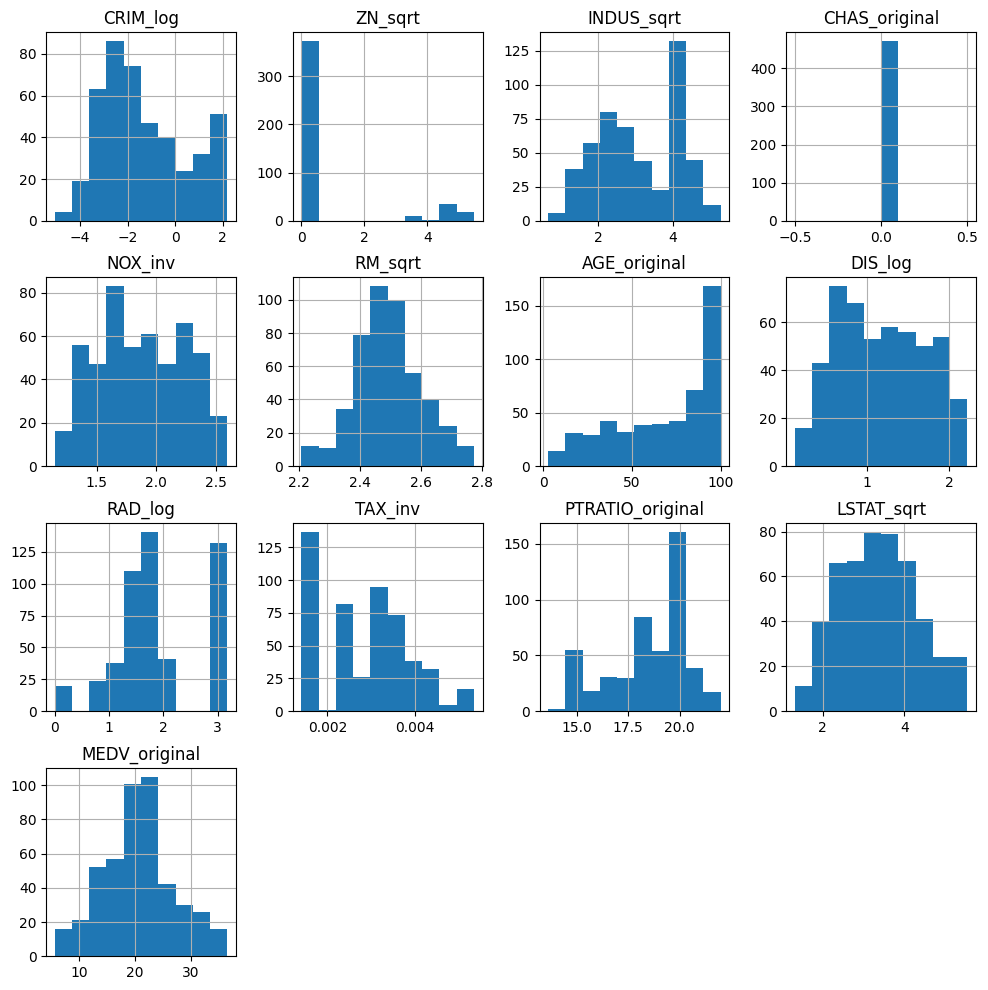

In [158]:
# Si bien no son perfectas, tienen una simetría más cercana a 0
trans_data.hist(figsize=(12,12))
plt.show()

In [161]:
# Volvemos a separar en train / test
split = X_train.shape[0]

train_df = trans_data.loc[:split]
test_df = trans_data.loc[split:]

In [166]:
# Por último, escalamos todos los datos
scaler = StandardScaler()

scaled_train = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
scaled_test = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

### Correlación

In [169]:
# La variable con una correlación más fuerte es LSTAT
scaled_train.corr()['MEDV_original'].sort_values(ascending=False, key=abs)

MEDV_original       1.000000
LSTAT_sqrt         -0.800223
INDUS_sqrt         -0.646767
NOX_inv             0.606941
RM_sqrt             0.581660
AGE_original       -0.571883
TAX_inv             0.569830
DIS_log             0.539006
CRIM_log           -0.523172
RAD_log            -0.498815
PTRATIO_original   -0.420834
ZN_sqrt             0.292362
CHAS_original            NaN
Name: MEDV_original, dtype: float64

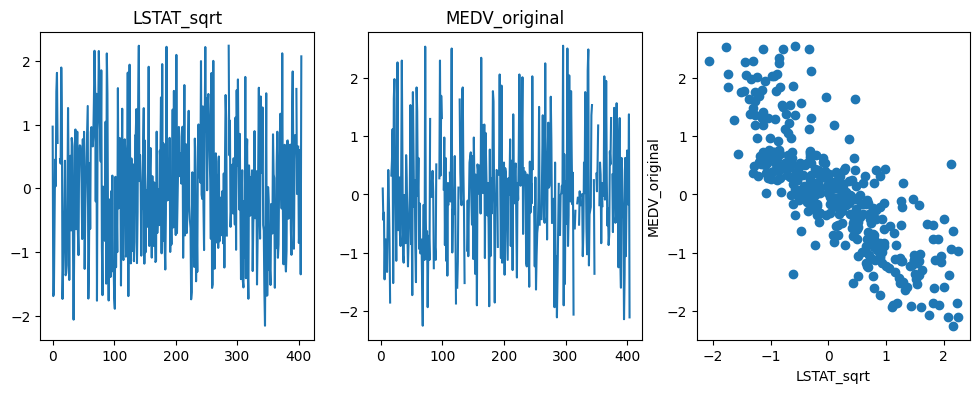

In [171]:
feature_col = 'LSTAT_sqrt'
target_col = 'MEDV_original'

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4))

ax1.plot(scaled_train[feature_col])
ax1.set_title(feature_col)

ax2.plot(scaled_train[target_col])
ax2.set_title(target_col)

ax3.scatter(scaled_train[feature_col], scaled_train[target_col])
ax3.set_xlabel(feature_col)
ax3.set_ylabel(target_col)

plt.show()

### Red neuronal

In [198]:
train_m1 = scaled_train[[feature_col, target_col]]
test_m1 = scaled_test[[feature_col, target_col]]

train_m1 = train_m1.dropna()
test_m1 = test_m1.dropna()

In [192]:
tf.random.set_seed(1234)

# Definir la arquitectura de la red neuronal
model1 = keras.Sequential([
    keras.layers.Input(shape = (1,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                128       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [193]:
# Compilar el modelo
model1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Entrenar el modelo
hist1 = model1.fit(
    train_m1[feature_col], train_m1[target_col], 
    validation_split=0.2, 
    shuffle=False,
    epochs=200, 
    batch_size=32, 
    verbose=0
)

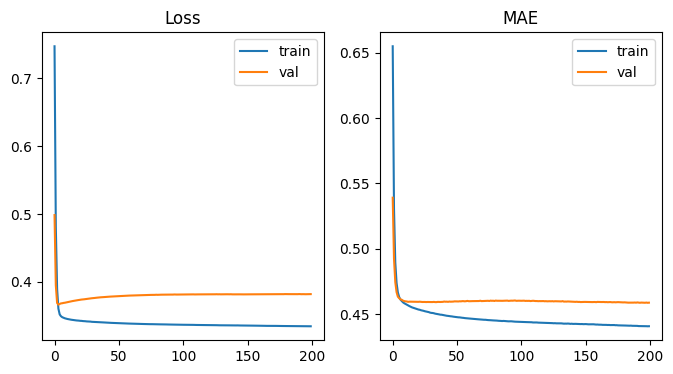

In [195]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

ax1.plot(hist1.history['loss'], label='train')
ax1.plot(hist1.history['val_loss'], label='val')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(hist1.history['mae'], label='train')
ax2.plot(hist1.history['val_mae'], label='val')
ax2.set_title('MAE')
ax2.legend()

plt.show()

In [207]:
mse_m1, mae_m1 = model1.evaluate(test_m1[feature_col], test_m1[target_col])

print('MSE', mse_m1)
print('MAE', mae_m1)

3/3 [==============================] - 0s 16ms/step - loss: 0.4631 - mae: 0.5220
MSE 0.46308624744415283
MAE 0.5219992995262146


3/3 [==============================] - 0s 3ms/step


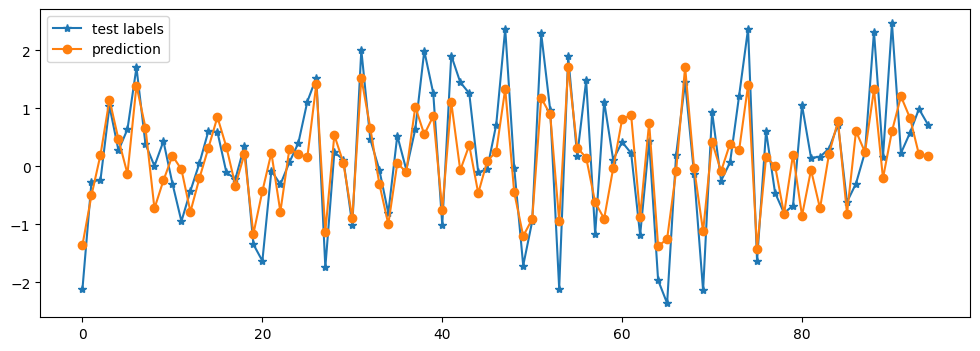

In [218]:
pred_m1 = model1.predict(test_m1[feature_col])

plt.figure(figsize=(12,4))
plt.plot(test_m1[target_col].values, '*-', label='test labels')
plt.plot(pred_m1, 'o-', label='prediction')

plt.legend()
plt.show()

Código de solución estudiante 2

In [ ]:
# Código de solución estudiante 2
.
.
.
.


### Ejercicio 2: 
Construir una red neuronal MLP multivariada. Para esto, tomar todas las variables incluidas en nuestro dataset.

Código de solución estudiante 1

In [210]:
feature_cols = [c for c in scaled_train.columns if c!=target_col]

train_m2 = scaled_train.copy()
test_m2= scaled_test.copy()

train_m2 = train_m2.dropna()
test_m2 = test_m2.dropna()

In [211]:
model2 = keras.Sequential([
    keras.layers.Input(shape = (len(feature_cols),)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                832       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________


In [212]:
# Compilar el modelo
model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Entrenar el modelo
hist2 = model2.fit(
    train_m2[feature_cols], train_m2[target_col], 
    validation_split=0.2, 
    shuffle=False,
    epochs=200, 
    batch_size=32, 
    verbose=0
)

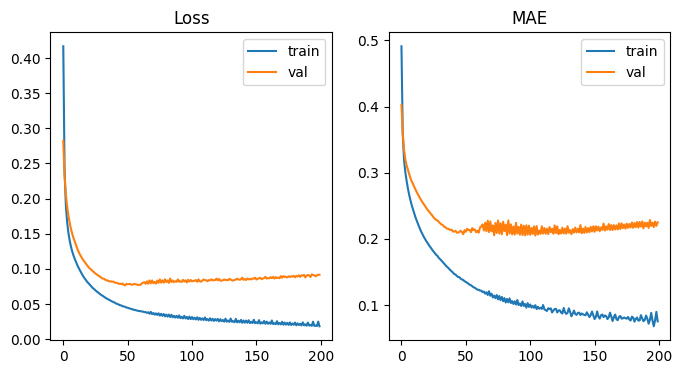

In [213]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

ax1.plot(hist2.history['loss'], label='train')
ax1.plot(hist2.history['val_loss'], label='val')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(hist2.history['mae'], label='train')
ax2.plot(hist2.history['val_mae'], label='val')
ax2.set_title('MAE')
ax2.legend()

plt.show()

In [214]:
mse_m2, mae_m2 = model2.evaluate(test_m2[feature_cols], test_m2[target_col])

print('MSE', mse_m2)
print('MAE', mae_m2)

2/2 [==============================] - 0s 9ms/step - loss: 0.2517 - mae: 0.3710
MSE 0.251691609621048
MAE 0.3710440993309021


2/2 [==============================] - 0s 5ms/step


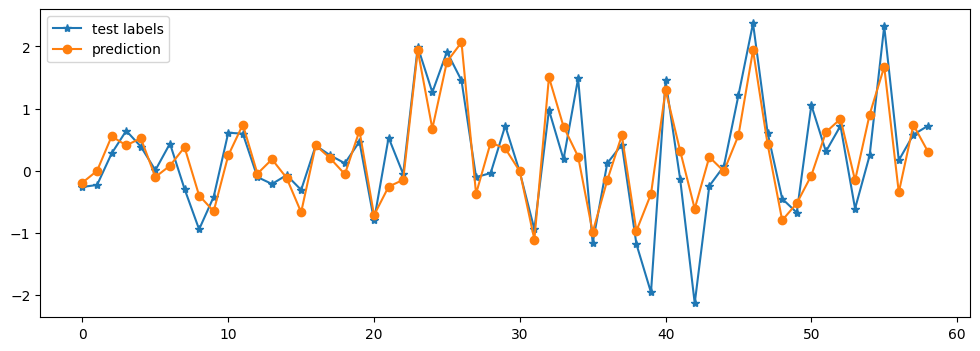

In [219]:
pred_m2 = model2.predict(test_m2[feature_cols])

plt.figure(figsize=(12,4))
plt.plot(test_m2[target_col].values, '*-', label='test labels')
plt.plot(pred_m2, 'o-', label='prediction')

plt.legend()
plt.show()

Código de solución estudiante 2

In [0]:
# Código de solución estudiante 2
.
.
.
.


### Ejercicio 3: 
Construir una red neuronal MLP multivariada, pero en este caso sólo considerar las variables adecuadas y descartar aquellas que no aportan mucha información o que son redundantes para cuantificar el efecto de estas variables redundantes.

Luego del paso 3, crear el mismo modelo pero en este caso implementar técnicas de regularización `EarlyStoppin` y `dropout`. Investigar como se pueden implementar estas estrategias en tensorflow.

Código de solución estudiante 1

In [272]:
def get_steps(values):
    min_v, max_v = values.min(), values.max()
    step = (max_v - min_v) / len(values)

    return np.arange(min_v, max_v + step, step, dtype=float)

In [228]:
def create_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape = input_shape),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    return model

In [229]:
feature_cols = [c for c in scaled_train.columns if c!=target_col]

train_m3 = scaled_train.copy()
test_m3= scaled_test.copy()

train_m3 = train_m3.dropna()
test_m3 = test_m3.dropna()

### Threshold por correlación

In [276]:
values = np.abs(scaled_train.corr()[target_col])
values.drop(['CHAS_original', target_col], axis=0, inplace=True)
steps = get_steps(values)

index_vistos = []
eval_corr = {}
index = 0

for threshold in steps:
    selected_cols = values.loc[values >= threshold].index.tolist()
    
    if len(selected_cols) == 0:
        continue
        
    if selected_cols in index_vistos:
        continue
        
    index_vistos.append(selected_cols)
    
    #Modelo
    model = create_model(input_shape=(len(selected_cols), ))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    # Entrenar el modelo
    model.fit(
        train_m3[selected_cols], train_m3[target_col], 
        validation_split=0.2, 
        shuffle=False,
        epochs=200, 
        batch_size=32, 
        verbose=0
    )
    
    mse, mae = model.evaluate(test_m3[selected_cols], test_m3[target_col])

    #Guardar
    eval_corr[index] = {'threshold': threshold,
                        'variables': selected_cols,
                        'mse': mse,
                        'mae': mae}
    index += 1

2/2 [==============================] - 0s 5ms/step - loss: 0.4546 - mae: 0.4903


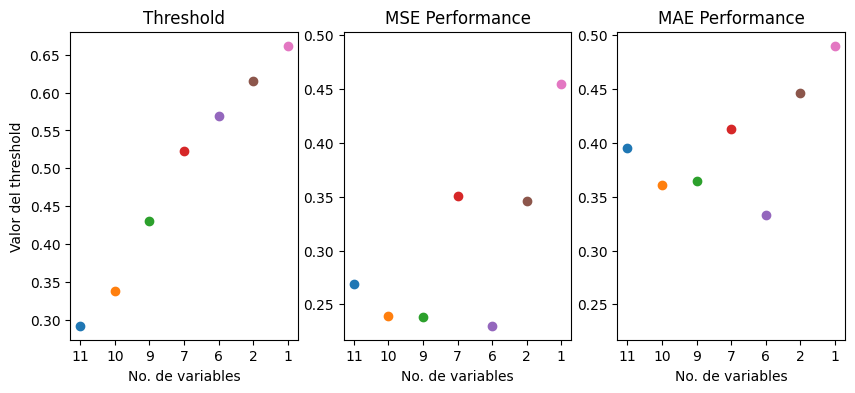

In [277]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3, sharey=ax2)
#fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
etiquetas = []

for index, eval in eval_corr.items():

    variables = str(len(eval['variables']))
    etiquetas.append(variables)
    
    # Graficar threshold
    th_label = f"{np.round(eval['threshold'], 4)}"
    ax1.scatter(index, eval['threshold'], label=th_label)
    
    # Graficar performance
    mse_label = f"{np.round(eval['mse'], 2)}"
    ax2.scatter(index, eval['mse'], label=mse_label)
    
    mae_label = f"{np.round(eval['mae'], 2)}"
    ax3.scatter(index, eval['mae'], label=mae_label)

ax1.set_title('Threshold')
ax2.set_title('MSE Performance')
ax3.set_title('MAE Performance')

ax1.set_xticks(range(len(etiquetas)))
ax1.set_xticklabels(etiquetas)
ax1.set_xlabel('No. de variables')
ax1.set_ylabel('Valor del threshold')

ax2.set_xticks(range(len(etiquetas)))
ax2.set_xticklabels(etiquetas)
ax2.set_xlabel('No. de variables')

ax3.set_xticks(range(len(etiquetas)))
ax3.set_xticklabels(etiquetas)
ax3.set_xlabel('No. de variables')

plt.show()

El threshold de correlación en 0.56 con 6 variables parece dar muy buenos resultados.

In [283]:
eval_corr[4]

{'threshold': 0.5693772809006399,
 'variables': ['INDUS_sqrt',
  'NOX_inv',
  'RM_sqrt',
  'AGE_original',
  'TAX_inv',
  'LSTAT_sqrt'],
 'mse': 0.23009559512138367,
 'mae': 0.33310467004776}

In [284]:
feature_cols = eval_corr[4]['variables']

model3 = create_model(len(feature_cols))
model3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

hist3 = model3.fit(
    train_m3[feature_cols], train_m3[target_col], 
    validation_split=0.2, 
    shuffle=False,
    epochs=200, 
    batch_size=32, 
    verbose=0
)

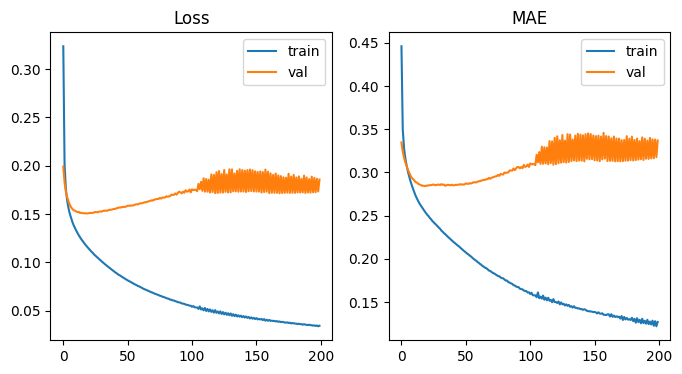

In [285]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

ax1.plot(hist3.history['loss'], label='train')
ax1.plot(hist3.history['val_loss'], label='val')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(hist3.history['mae'], label='train')
ax2.plot(hist3.history['val_mae'], label='val')
ax2.set_title('MAE')
ax2.legend()

plt.show()

In [286]:
mse_m3, mae_m3 = model3.evaluate(test_m3[feature_cols], test_m3[target_col])

print('MSE', mse_m3)
print('MAE', mae_m3)

2/2 [==============================] - 0s 31ms/step - loss: 0.2575 - mae: 0.3526
MSE 0.2575138509273529
MAE 0.3525916337966919


2/2 [==============================] - 0s 13ms/step


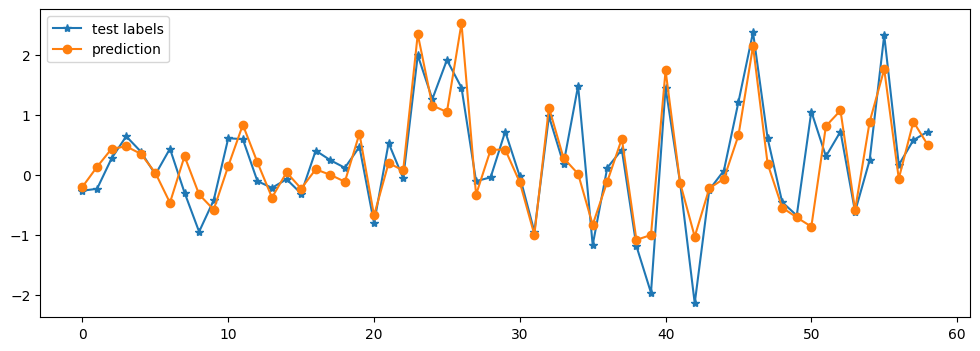

In [287]:
pred_m3 = model3.predict(test_m3[feature_cols])

plt.figure(figsize=(12,4))
plt.plot(test_m3[target_col].values, '*-', label='test labels')
plt.plot(pred_m3, 'o-', label='prediction')

plt.legend()
plt.show()

### Resultados

In [288]:
metrics = pd.DataFrame(index=['model_1', 'model_2', 'model_3'])
metrics['mse'] = [mse_m1, mse_m2, mse_m3]
metrics['mae'] = [mae_m1, mae_m2, mae_m3]

metrics

,mse,mae
model_1,0.463086,0.521999
model_2,0.251692,0.371044
model_3,0.257514,0.352592


Código de solución estudiante 2

In [0]:
# Código de solución estudiante 2
.
.
.
.
